VERSION NOTES:
- TradedFactorModel for everything?
- test joint significance of macro and FF3
- try LinearFactorModels with GDP directly
- robustness tests (out-of-sample factor on real data, alternative variables, monthly, etc)

# Asset Pricing Tests

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel.model import FamaMacBeth
from linearmodels.asset_pricing import TradedFactorModel
from linearmodels.asset_pricing import LinearFactorModel
from linearmodels.asset_pricing import LinearFactorModelGMM as GMM

## Data

In [2]:
ff_data = pd.read_csv('ff_data.csv', index_col=0, parse_dates=True)
monthly_factors = pd.read_csv('monthly_factors.csv', index_col=0, parse_dates=True)
quarterly_factors = pd.read_csv('quarterly_factors.csv', index_col=0, parse_dates=True)

In [3]:
# Monthly
# Test asset clean up
ff_data = ff_data.loc[monthly_factors.index[0]:monthly_factors.index[-1]] / 100

# Factor Models
ff3 = ff_data.iloc[:,0:3]
ff5 = ff_data.iloc[:,0:5]
ff5_mom = pd.concat([ff5, ff_data.iloc[:,31]], axis=1)

# Test Asset Portfolios
size_book_assets_m = ff_data.iloc[:,6:31].apply(lambda x: x - ff_data['RF'])
industry_assets_m = ff_data.iloc[:,32:].apply(lambda x: x - ff_data['RF'])

# Macro Factors
factors_m = pd.concat([monthly_factors, ff_data['Mkt-RF']], axis=1)

In [4]:
# Quarterly
def f(data, last_row=False):
    '''
    Computes the buy and hold for 3 month (1 quarter) return.
    '''
    df = ((1+data).cumprod(axis=0)-1)

    return df.iloc[-1]

ff_data_q = (ff_data).resample('Q').apply(f).iloc[1:-2]

# Factor Models
ff3_q = ff_data_q.iloc[:,0:3]
ff5_q = ff_data_q.iloc[:,0:5]
ff5_mom_q = pd.concat([ff5_q, ff_data_q.iloc[:,31]], axis=1)

# Test Asset Portfolios
size_book_assets_q = ff_data_q.iloc[:,6:31].apply(lambda x: x - ff_data_q['RF'])
industry_assets_q = ff_data_q.iloc[:,32:].apply(lambda x: x - ff_data_q['RF'])

# Macro Factors
factors_q = pd.concat([quarterly_factors, ff_data_q['Mkt-RF']], axis=1).dropna()

## Analysis

Two sets of test assets will be used: 
1) 25 Size-Book Sorted Portfolios 
2) 30 Industry Portfolios

Several factor models will be tested (on each set of test assets):
1) Macro Factors
    - how well do they price the cross-section?
    - what are their risk premia if any?
2) Macro Factors + Market Factor
3) FF3
    - Compare Macro Factors to FF3
4) FF3 + Macro Factors
    - Given the Macro Factors are SMB + HML needed?
5) FF5
6) FF5 + Momentum
    - do the Macro Factors price better than the standard model?
7) FF5 + Momentum + Macro Factors
    - is the standard model subsumed by the Macro Factors?

In [7]:
macro_factors = factors_q[['gdp_4qoq', 'cpi_4qoq', 'Mkt-RF']]

### GRS Test

In [19]:
# Function based on: https://medium.com/@gunsberg/python-grs-test-for-asset-pricing-models-in-linearmodels-v-4-25-69b54832d08d
from scipy.stats import f
from scipy.stats import chi2

def grs(model, factors):
    '''
    Function to compute the GRS test stat (pg 233 of Cochrane).
    'model' is model output from LinearModels Traded or Linear FactorModel.
    '''
    # Time, portfolios, factors
    T = model.nobs
    N , K = model.betas.shape

    # Coefficient (a)
    a = (T - N - K) / N

    # Factor Sharpe Ratio (b)
    E_f = factors.mean()
    omega_hat = (1/T)*((factors - E_f).T @ (factors - E_f)) # K x K
    omega_hat_inv = np.linalg.pinv(omega_hat)  # pseudo-inverse
    b = 1 + (E_f.T @ omega_hat_inv @ E_f) # (1 X K) x (K X K) x (K X 1) = 1 x 1
    b_inv = b**(-1)
   
    # Pricing Errors (c)
    sigma_hat = model.std_errors
    sigma_hat = sigma_hat @ sigma_hat.T 
    sigma_hat_inv = np.linalg.pinv(sigma_hat)
    alpha_hat = model.alphas
    c = alpha_hat @ sigma_hat_inv @ alpha_hat.T
   

    # GRS Stat
    grs = a * b_inv * c
    grs_p_val = 1 - f.cdf(grs, N, T - N - K)
    
    return {'GRS Statistic':f'{grs:0.2f}', 'p-value':f'{grs_p_val:0.5f}'}

### Fama-MacBeth (Full-Sample)

In [6]:
def factor_models(test_assets, macro_factors):
    '''
    Runs all factor models on the given set of test assets.
    Stores the model instances in a dictionary.
    '''
    
    model_results = {}
    
    # Macro Factors
    model1 = LinearFactorModel(test_assets, macro_factors.iloc[:,:2]).fit(cov_type='kernel')
    model_results['macro'] = model1
   
    # Macro Factors + Market
    model2 = LinearFactorModel(test_assets, macro_factors.iloc[:,:]).fit(cov_type='kernel')
    model_results['macro+mkt'] = model2
   
    # FF3
    model3 = TradedFactorModel(test_assets, ff3_q).fit(cov_type='kernel')
    model_results['ff3'] = model3
    
    # FF3 + Macro Factors
    model4 = LinearFactorModel(test_assets, pd.concat([ff3_q, macro_factors.iloc[:,:2]], axis=1)).fit(cov_type='kernel')
    model_results['ff3+macro'] = model4
    
    # FF5
    model5 = TradedFactorModel(test_assets, ff5_q).fit(cov_type='kernel')
    model_results['ff5'] = model5
    
    # FF5 + Momentum
    model6 = TradedFactorModel(test_assets, ff5_mom_q).fit(cov_type='kernel')
    model_results['ff5+mom'] = model6
     
    # FF5 + Momentum + Macro Factors
    model7 = LinearFactorModel(test_assets, pd.concat([ff5_mom_q, macro_factors.iloc[:,:2]], axis=1)).fit(cov_type='kernel')
    model_results['ff5+macro'] = model7
    
    return model_results

In [270]:
size_book_models_mom['macro+mkt']

NameError: name 'size_book_models_mom' is not defined

GDP's risk premia becomes insignificant (not a surprise from the factor creation stage).

CPI's premia is highly significant, negative and very small.

In [75]:
size_book_models_mom['macro+mkt']._jstat

J-statistic
H0: All alphas are 0
Statistic: 89.0458
P-value: 0.0000
Distributed: chi2(25)
WaldTestStatistic, id: 0x2ad5f4aed00

In [77]:
12*size_book_models_mom['macro+mkt'].alphas.sort_values()

SMALL LoBM   -0.070035
ME2 BM1      -0.026450
ME3 BM1      -0.022094
BIG LoBM     -0.002565
ME4 BM1       0.000389
ME5 BM4       0.002473
ME5 BM2       0.011611
ME1 BM2       0.012548
ME4 BM2       0.012643
ME1 BM3       0.015558
ME5 BM3       0.015651
ME2 BM2       0.015721
BIG HiBM      0.017111
ME4 BM3       0.018343
ME3 BM3       0.019770
ME3 BM2       0.023827
ME2 BM3       0.024028
ME4 BM4       0.024414
ME3 BM4       0.032213
ME4 BM5       0.033756
ME2 BM4       0.036667
ME2 BM5       0.039072
ME1 BM4       0.044953
ME3 BM5       0.049590
SMALL HiBM    0.053801
Name: alpha, dtype: float64

Reject null that alphas are 0 for the Macro + Mkt Model; the model does not price the portfolios.

The J-statistic itself is the lowest amoung all the models (even FF5+Momentum+Macro). The biggest pricing errors are in the more extreme portfolios (particularly the "SMALL" portfolios).

In [80]:
size_book_models_mom['ff5+mom']._jstat

J-statistic
H0: All alphas are 0
Statistic: 91.4080
P-value: 0.0000
Distributed: chi2(25)
WaldTestStatistic, id: 0x2ad5f556880

In [82]:
size_book_models_mom['ff5+macro']._jstat

J-statistic
H0: All alphas are 0
Statistic: 80.5827
P-value: 0.0000
Distributed: chi2(25)
WaldTestStatistic, id: 0x2ad5f57d340

Adding macro to FF5 + Momentum enhances pricing (marginally).

In [83]:
size_book_models_mom['ff3+macro']

TradedFactorModel Estimation Summary                      
================================================================================
No. Test Portfolios:                 25   R-squared:                      0.9174
No. Factors:                          5   J-statistic:                    83.636
No. Observations:                   595   P-value                         0.0000
Date:                  Sat, Mar 18 2023   Distribution:                 chi2(25)
Time:                          17:53:21                                         
Cov. Estimator:                  kernel                                         
                                                                                
                            Risk Premia Estimates                             
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         0.0061     0.0019     3.1229     0.0018      0.0023      0.0099
SMB            0.0022     0.0012     1.7837     0.0745     -0.0002      0.0046
HML            0.0030     0.0016     1.9047     0.0568  -8.807e-05      0.0062
gdp_0          0.0002     0.0001     1.3668     0.1717  -6.779e-05      0.0004
cpi_0         -0.0001  3.598e-05    -2.9089     0.0036     -0.0002  -3.415e-05
==============================================================================

Covariance estimator:
KernelCovariance, Kernel: bartlett, Bandwidth: 9
See full_summary for complete results
LinearFactorModelResults, id: 0x2ad5f5569d0

Macro factors do not subsume SMB and HML; GDP remains insignificant while CPI is still highly significant.

In [93]:
size_book_models_yoy['macro+mkt']

TradedFactorModel Estimation Summary                      
================================================================================
No. Test Portfolios:                 25   R-squared:                      0.7263
No. Factors:                          3   J-statistic:                    87.233
No. Observations:                   595   P-value                         0.0000
Date:                  Sat, Mar 18 2023   Distribution:                 chi2(25)
Time:                          17:53:21                                         
Cov. Estimator:                  kernel                                         
                                                                                
                            Risk Premia Estimates                             
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
gdp_1          0.0004     0.0002     1.9826     0.0474   4.684e-06      0.0008
cpi_1         -0.0005     0.0002    -2.4412     0.0146     -0.0009  -9.523e-05
Mkt-RF         0.0061     0.0019     3.1261     0.0018      0.0023      0.0099
==============================================================================

Covariance estimator:
KernelCovariance, Kernel: bartlett, Bandwidth: 7
See full_summary for complete results
LinearFactorModelResults, id: 0x2ad5f5fb760

In [94]:
size_book_models_yoy['macro+mkt']

TradedFactorModel Estimation Summary                      
================================================================================
No. Test Portfolios:                 25   R-squared:                      0.7263
No. Factors:                          3   J-statistic:                    87.233
No. Observations:                   595   P-value                         0.0000
Date:                  Sat, Mar 18 2023   Distribution:                 chi2(25)
Time:                          17:53:21                                         
Cov. Estimator:                  kernel                                         
                                                                                
                            Risk Premia Estimates                             
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
gdp_1          0.0004     0.0002     1.9826     0.0474   4.684e-06      0.0008
cpi_1         -0.0005     0.0002    -2.4412     0.0146     -0.0009  -9.523e-05
Mkt-RF         0.0061     0.0019     3.1261     0.0018      0.0023      0.0099
==============================================================================

Covariance estimator:
KernelCovariance, Kernel: bartlett, Bandwidth: 7
See full_summary for complete results
LinearFactorModelResults, id: 0x2ad5f5fb760

In [100]:
size_book_models_yoy['ff3+macro']

TradedFactorModel Estimation Summary                      
================================================================================
No. Test Portfolios:                 25   R-squared:                      0.9175
No. Factors:                          5   J-statistic:                    82.995
No. Observations:                   595   P-value                         0.0000
Date:                  Sat, Mar 18 2023   Distribution:                 chi2(25)
Time:                          17:53:21                                         
Cov. Estimator:                  kernel                                         
                                                                                
                            Risk Premia Estimates                             
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         0.0061     0.0019     3.1184     0.0018      0.0023      0.0099
SMB            0.0022     0.0012     1.7794     0.0752     -0.0002      0.0046
HML            0.0030     0.0016     1.8917     0.0585     -0.0001      0.0062
gdp_1          0.0004     0.0002     2.0255     0.0428   1.326e-05      0.0008
cpi_1         -0.0005     0.0002    -2.3973     0.0165     -0.0009  -8.813e-05
==============================================================================

Covariance estimator:
KernelCovariance, Kernel: bartlett, Bandwidth: 10
See full_summary for complete results
LinearFactorModelResults, id: 0x2ad5f64ba60

#### Quarterly

##### Test Assets: 25 Size-Book Value Sorted Portfolios

In [8]:
size_book_models = factor_models(size_book_assets_q, macro_factors)

In [9]:
size_book_models_mom['macro+mkt']

NameError: name 'size_book_models_mom' is not defined

GDP's risk premia becomes insignificant (not a surprise from the factor creation stage).

CPI's premia is highly significant, negative and very small.

In [75]:
size_book_models_mom['macro+mkt']._jstat

J-statistic
H0: All alphas are 0
Statistic: 89.0458
P-value: 0.0000
Distributed: chi2(25)
WaldTestStatistic, id: 0x2ad5f4aed00

In [77]:
12*size_book_models_mom['macro+mkt'].alphas.sort_values()

SMALL LoBM   -0.070035
ME2 BM1      -0.026450
ME3 BM1      -0.022094
BIG LoBM     -0.002565
ME4 BM1       0.000389
ME5 BM4       0.002473
ME5 BM2       0.011611
ME1 BM2       0.012548
ME4 BM2       0.012643
ME1 BM3       0.015558
ME5 BM3       0.015651
ME2 BM2       0.015721
BIG HiBM      0.017111
ME4 BM3       0.018343
ME3 BM3       0.019770
ME3 BM2       0.023827
ME2 BM3       0.024028
ME4 BM4       0.024414
ME3 BM4       0.032213
ME4 BM5       0.033756
ME2 BM4       0.036667
ME2 BM5       0.039072
ME1 BM4       0.044953
ME3 BM5       0.049590
SMALL HiBM    0.053801
Name: alpha, dtype: float64

Reject null that alphas are 0 for the Macro + Mkt Model; the model does not price the portfolios.

The J-statistic itself is the lowest amoung all the models (even FF5+Momentum+Macro). The biggest pricing errors are in the more extreme portfolios (particularly the "SMALL" portfolios).

In [80]:
size_book_models_mom['ff5+mom']._jstat

J-statistic
H0: All alphas are 0
Statistic: 91.4080
P-value: 0.0000
Distributed: chi2(25)
WaldTestStatistic, id: 0x2ad5f556880

In [82]:
size_book_models_mom['ff5+macro']._jstat

J-statistic
H0: All alphas are 0
Statistic: 80.5827
P-value: 0.0000
Distributed: chi2(25)
WaldTestStatistic, id: 0x2ad5f57d340

Adding macro to FF5 + Momentum enhances pricing (marginally).

In [83]:
size_book_models_mom['ff3+macro']

TradedFactorModel Estimation Summary                      
================================================================================
No. Test Portfolios:                 25   R-squared:                      0.9174
No. Factors:                          5   J-statistic:                    83.636
No. Observations:                   595   P-value                         0.0000
Date:                  Sat, Mar 18 2023   Distribution:                 chi2(25)
Time:                          17:53:21                                         
Cov. Estimator:                  kernel                                         
                                                                                
                            Risk Premia Estimates                             
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         0.0061     0.0019     3.1229     0.0018      0.0023      0.0099
SMB            0.0022     0.0012     1.7837     0.0745     -0.0002      0.0046
HML            0.0030     0.0016     1.9047     0.0568  -8.807e-05      0.0062
gdp_0          0.0002     0.0001     1.3668     0.1717  -6.779e-05      0.0004
cpi_0         -0.0001  3.598e-05    -2.9089     0.0036     -0.0002  -3.415e-05
==============================================================================

Covariance estimator:
KernelCovariance, Kernel: bartlett, Bandwidth: 9
See full_summary for complete results
LinearFactorModelResults, id: 0x2ad5f5569d0

Macro factors do not subsume SMB and HML; GDP remains insignificant while CPI is still highly significant.

In [10]:
size_book_models['macro+mkt']

LinearFactorModel Estimation Summary                      
================================================================================
No. Test Portfolios:                 25   R-squared:                      0.7580
No. Factors:                          3   J-statistic:                    88.312
No. Observations:                   196   P-value                         0.0000
Date:                  Sun, Mar 26 2023   Distribution:                 chi2(22)
Time:                          14:32:49                                         
Cov. Estimator:                  kernel                                         
                                                                                
                            Risk Premia Estimates                             
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
gdp_4qoq       0.0032     0.0038     0.8379     0.4021     -0.0043      0.0107
cpi_4qoq      -0.0085     0.0046    -1.8386     0.0660     -0.0176      0.0006
Mkt-RF         0.0208     0.0057     3.6658     0.0002      0.0097      0.0320
==============================================================================

Covariance estimator:
KernelCovariance, Kernel: bartlett, Bandwidth: 11
See full_summary for complete results
LinearFactorModelResults, id: 0x2610abb2be0

In [21]:
grs(size_book_models['macro+mkt'], macro_factors)

{'GRS Statistic': '0.35', 'p-value': '0.99857'}

In [22]:
# FF3 for comparison
ff3_model = TradedFactorModel(size_book_assets_q, ff3_q).fit(cov_type='kernel')
grs(ff3_model,ff3_q)

{'GRS Statistic': '10.81', 'p-value': '0.00000'}

##### Test Assets: 30 Industry Portfolios

In [23]:
industry_models = factor_models(industry_assets_q, macro_factors)

In [24]:
industry_models['macro+mkt']

LinearFactorModel Estimation Summary                      
================================================================================
No. Test Portfolios:                 30   R-squared:                      0.5852
No. Factors:                          3   J-statistic:                    214.82
No. Observations:                   196   P-value                         0.0000
Date:                  Sun, Mar 26 2023   Distribution:                 chi2(27)
Time:                          14:33:51                                         
Cov. Estimator:                  kernel                                         
                                                                                
                            Risk Premia Estimates                             
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
gdp_4qoq       0.0002     0.0036     0.0531     0.9577     -0.0068      0.0072
cpi_4qoq       0.0022     0.0023     0.9266     0.3541     -0.0024      0.0068
Mkt-RF         0.0217     0.0039     5.6291     0.0000      0.0141      0.0292
==============================================================================

Covariance estimator:
KernelCovariance, Kernel: bartlett, Bandwidth: 28
See full_summary for complete results
LinearFactorModelResults, id: 0x2610b523d30

In [25]:
grs(industry_models['macro+mkt'], macro_factors)

{'GRS Statistic': '0.47', 'p-value': '0.99208'}

In [26]:
# FF3 for comparison
ff3_model = TradedFactorModel(industry_assets_q, ff3_q).fit(cov_type='kernel')
grs(ff3_model,ff3_q)

{'GRS Statistic': '4.72', 'p-value': '0.00000'}

In [27]:
def fama_macbeth(test_assets, factors):
    '''
    Function to perform Fama-MacBeth procedure.
    '''
    from scipy.stats import chi2
    
    # Time Series Regression
    betas = []
    
    for portfolio in test_assets:
        ts = sm.OLS(test_assets.loc[:,portfolio], sm.add_constant(factors)).fit()
        betas.append(ts.params[1:])

    betas = pd.DataFrame(betas)
    betas.index = test_assets.columns
    
    # Cross Sectional Regressions
    T = len(factors)
    lambdas = []
    alphas = []
    
    for t in range(T):
        cs = sm.OLS(np.array(test_assets)[t].T, betas).fit()
        lambdas.append(cs.params)
        alphas.append(cs.resid)
            
    # Risk Premia significance (without controlling for autocorrelation)
    lambdas_df = pd.DataFrame(lambdas)
    
    std_errors = lambdas_df.apply(lambda col: np.sqrt(((col - col.mean())**2).sum() / T**2))
    t_stats = lambdas_df.mean() / std_errors
    
    premia = pd.merge(lambdas_df.mean().rename('Risk Premia'), t_stats.rename('t-stat'), left_index=True, right_index=True)
    
    # Alpha significance (without controlling for autocorrelation)
    alphas_df = pd.DataFrame(alphas)
    alpha_hat = alphas_df.mean()

    cov_alpha = ((alphas_df - alpha_hat).T @ (alphas_df - alpha_hat)) / len(alphas_df)**2
    
    alpha_chi = alpha_hat.T @ np.linalg.inv(cov_alpha) @ alpha_hat
    alpha_p_val = 1 - chi2.cdf(alpha_chi, df=len(alpha_hat)-len(premia))

    alpha_hat_mean = abs(alpha_hat).mean()
    alpha = pd.DataFrame({'Test Statistic': alpha_chi, 'p-value':alpha_p_val, 'Mean Absolute alpha':alpha_hat_mean}, index=['H0: alphas=0'])
    
    return (premia, alpha)

### Fama-MacBeth (Split-Sample)

In [44]:
def get_premia(model):
    '''
    Function to output estimated risk premia and t-statistics
    '''
    premia = pd.DataFrame({'Risk Premia':model.risk_premia, 't-stat':model.risk_premia_tstats, 'Standard Error':model.risk_premia_se})

    return premia

In [45]:
def get_alpha(model, factors):
    '''
    Function to output GRS test for alphas, and mean absolute alpha
    '''    
    grs_test = grs(model, factors)
    
    grs_stat = grs_test['GRS Statistic']
    grs_p_val = grs_test['p-value']
    
    alpha_hat_mean = abs(model.alphas).mean()
    
    alpha = pd.DataFrame({'GRS Statistic':grs_stat, 'p-value':grs_p_val, 'Mean Absolute alpha':alpha_hat_mean}, index=['H0: alphas=0'])
    
    return alpha

In [46]:
def multiple_models(test_assets, start='1973', end='2022'):
    '''
    Function to run several pricing models.
    Start and end allow for custom dates.
    '''
    # Models
    macro_model = LinearFactorModel(test_assets.loc[start:end], macro_factors.loc[start:end]).fit(cov_type='kernel')
    ff3 = TradedFactorModel(test_assets.loc[start:end], ff3_q.loc[start:end]).fit(cov_type='kernel')
    ff5_mom = TradedFactorModel(test_assets.loc[start:end], ff5_mom_q.loc[start:end]).fit(cov_type='kernel')
    
    # Output
    premia = pd.concat({'Macro Model':get_premia(macro_model),'FF3':get_premia(ff3), 'FF5 + MoM':get_premia(ff5_mom)})
    premia.index.names = ["Model", "Factors"]

    alpha = pd.concat({'Macro Model':get_alpha(macro_model,macro_factors),'FF3':get_alpha(ff3,ff3_q), 'FF5 + MoM':get_alpha(ff5_mom,ff5_mom_q)}, names=['Model', 'Hypothesis'])
    alpha.index = alpha.index.swaplevel(0,1)
    
    return (premia, alpha)

##### Test Assets: 25 Size-Book Value Sorted Portfolios

In [47]:
# Full-Sample (1973Q3 - 2022Q2)
full_sample0 = multiple_models(size_book_assets_q)[0]
full_sample1 = multiple_models(size_book_assets_q)[1]

display(full_sample0)
display(full_sample1)

Risk Premia    t-stat  Standard Error
Model       Factors                                        
Macro Model gdp_4qoq     0.003206  0.837892        0.003826
            cpi_4qoq    -0.008500 -1.838632        0.004623
            Mkt-RF       0.020838  3.665838        0.005684
FF3         Mkt-RF       0.019236  3.041706        0.006324
            SMB          0.006811  1.798767        0.003786
            HML          0.009362  1.856643        0.005042
FF5 + MoM   Mkt-RF       0.019236  3.387255        0.005679
            SMB          0.006811  1.689641        0.004031
            HML          0.009362  1.848879        0.005064
            RMW          0.009275  2.625577        0.003532
            CMA          0.009985  2.888319        0.003457
            Mom          0.017677  3.593523        0.004919

GRS Statistic  p-value  Mean Absolute alpha
Hypothesis   Model                                                  
H0: alphas=0 Macro Model          0.35  0.99857             0.002736
             FF3                 10.81  0.00000             0.003116
             FF5 + MoM          117.80  0.00000             0.002669

In [48]:
# Vassalou Sample ( - 1998Q4)
pre0 = multiple_models(size_book_assets_q, end='1998')[0]
pre1 = multiple_models(size_book_assets_q, end='1998')[1]

display(pre0)
display(pre1)

Risk Premia    t-stat  Standard Error
Model       Factors                                        
Macro Model gdp_4qoq     0.010423  1.695591        0.006147
            cpi_4qoq    -0.009193 -1.275069        0.007210
            Mkt-RF       0.022742  3.421242        0.006647
FF3         Mkt-RF       0.020781  2.464042        0.008434
            SMB          0.005543  1.032099        0.005370
            HML          0.013923  2.528973        0.005505
FF5 + MoM   Mkt-RF       0.020781  2.556167        0.008130
            SMB          0.005543  1.016371        0.005453
            HML          0.013923  2.547840        0.005464
            RMW          0.007826  2.647835        0.002956
            CMA          0.010982  2.999468        0.003661
            Mom          0.026031  4.870415        0.005345

GRS Statistic  p-value  Mean Absolute alpha
Hypothesis   Model                                                  
H0: alphas=0 Macro Model          0.05  1.00000             0.003773
             FF3                 55.28  0.00000             0.001982
             FF5 + MoM           94.67  0.00000             0.003788

In [49]:
# Post-Vassalou Sample (1998Q4 - )
post0 = multiple_models(size_book_assets_q, start='1999')[0]
post1 = multiple_models(size_book_assets_q, start='1999')[1]

display(post0)
display(post1)

Risk Premia    t-stat  Standard Error
Model       Factors                                        
Macro Model gdp_4qoq     0.003332  0.724188        0.004600
            cpi_4qoq     0.001314  0.308989        0.004252
            Mkt-RF       0.019345  2.674173        0.007234
FF3         Mkt-RF       0.017560  1.894193        0.009270
            SMB          0.008186  1.550129        0.005281
            HML          0.004414  0.536910        0.008220
FF5 + MoM   Mkt-RF       0.017560  1.838326        0.009552
            SMB          0.008186  1.621028        0.005050
            HML          0.004414  0.512211        0.008617
            RMW          0.010847  1.620191        0.006695
            CMA          0.008902  1.647464        0.005403
            Mom          0.008612  0.884530        0.009737

GRS Statistic  p-value  Mean Absolute alpha
Hypothesis   Model                                                  
H0: alphas=0 Macro Model          1.47  0.10761             0.004348
             FF3                 86.95  0.00000             0.004599
             FF5 + MoM           43.24  0.00000             0.003469

### Fama-MacBeth (Rolling)

In [50]:
def rolling_model(test_assets):
    '''
    Implements a 5 year (20 quarter) rolling Fama-MacBeth estimation of risk-premia.
    '''
    premia = []
    
    for t in range(len(test_assets)-20):
        model = LinearFactorModel(test_assets.iloc[t:t+20], macro_factors.iloc[t:t+20]).fit(cov_type='kernel')
        premia.append(get_premia(model).stack(-1))
        
    premia_df = pd.DataFrame(premia, index=test_assets.index[20:])
    
    return premia_df

In [51]:
rolling = rolling_model(size_book_assets_q)

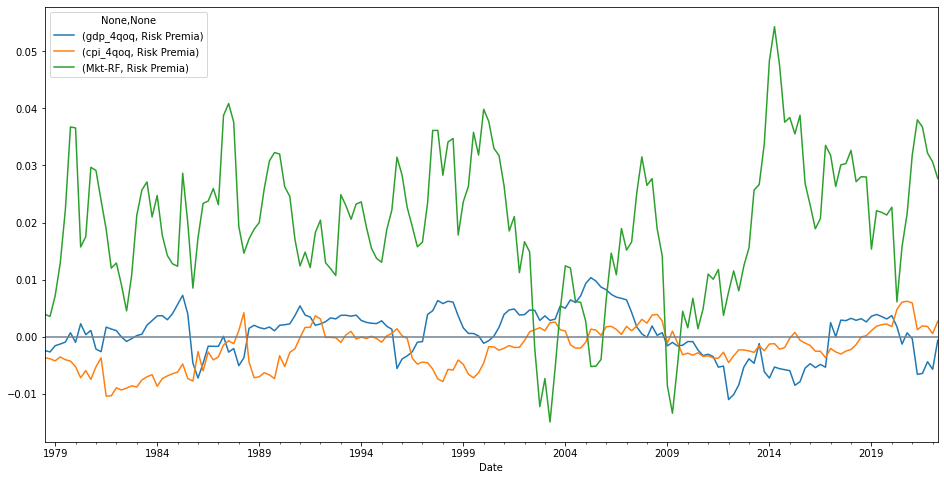

In [78]:
rolling.iloc[:, rolling.columns.get_level_values(1)=='Risk Premia'].iloc[:].plot(figsize=(16,8)).hlines(y=0, xmin=0, xmax=1000, color='slategrey')

<AxesSubplot:xlabel='Date'>

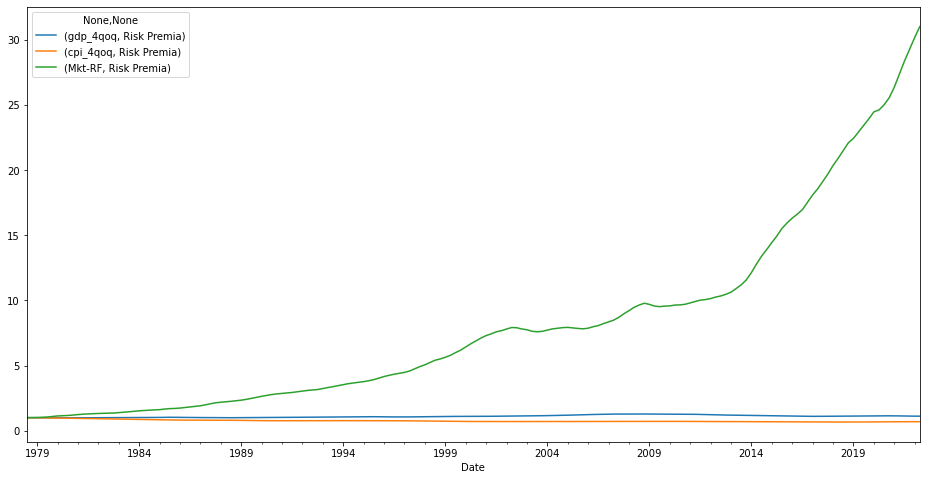

In [80]:
(1+rolling.iloc[:, rolling.columns.get_level_values(1)=='Risk Premia']).cumprod().plot(figsize=(16,8))

Above plots suggest that GDP and CPI are simply hedging factors: they do not have a stable non-zero risk premia.

In [158]:
# Plot with premia over time and standard errors
# rolling

In [89]:
model1 = TradedFactorModel(size_book_assets_q, macro_factors).fit(cov_type='kernel')
grs(model1,macro_factors)

{'GRS Statistic': '64.97', 'p-value': '0.00000'}

In [90]:
model2 = LinearFactorModel(size_book_assets_q, macro_factors).fit(cov_type='kernel')
grs(model2,macro_factors)

{'GRS Statistic': '0.35', 'p-value': '0.99857'}

In [94]:
model3 = TradedFactorModel(size_book_assets_q, ff3_q).fit(cov_type='kernel')
grs(model3,ff3_q)

{'GRS Statistic': '10.81', 'p-value': '0.00000'}

In [96]:
abs(model1.alphas).mean()

0.005499027136911869

In [98]:
abs(model2.alphas).mean()

0.002736241409533808

In [99]:
abs(model3.alphas).mean()

0.003116204074023205

### GMM?

In [81]:
gmm1 = GMM(size_book_assets_q, macro_factors).fit(cov_type='kernel')

Iteration: 0, Objective: 408.81821994372325
Iteration: 10, Objective: 231.58366663524419
Iteration: 20, Objective: 159.82101135600348
Iteration: 30, Objective: 125.20989728030852
Iteration: 40, Objective: 87.90685233654223
Iteration: 50, Objective: 72.00144667574065
Iteration: 60, Objective: 52.98657235710436
Iteration: 70, Objective: 46.82540545399147
Iteration: 80, Objective: 41.396768503671396
Iteration: 90, Objective: 36.867982556824295
Iteration: 100, Objective: 35.54196785001792
Iteration: 110, Objective: 31.253456957083067
Iteration: 120, Objective: 26.90832170140755
Iteration: 130, Objective: 23.338000573222892
Iteration: 140, Objective: 20.702454283272303
Iteration: 150, Objective: 19.264845899736102
Iteration: 160, Objective: 18.46583806747167
Iteration: 170, Objective: 17.933542092169578
Iteration: 180, Objective: 17.746642826476574
Iteration: 190, Objective: 17.680696308200325
Iteration: 200, Objective: 17.617758054037715
Iteration: 210, Objective: 17.58538951528697
Iterati

In [84]:
grs(gmm1,macro_factors)

{'GRS Statistic': '0.00', 'p-value': '1.00000'}

## Robustness Tests

### "Full-Sample" Analysis with OOS Factor

### Alternative Variables

- ISM for GDP
- Oil prices for CPI

### Monthly

- BBK monthly GDP
- CPI at its original (monthly) frequency